# Data Preprocess

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
from sklearn.metrics import roc_auc_score

In [3]:
df=pd.read_csv('Root_Insurance_data.csv')
df['if_clicked']=0
df.loc[df.click == True,'if_clicked']=1
df['if_married']=0
df.loc[df['Marital Status'] == 'M','if_married']=1
####below I treat unknown section as 0.5, which is different from others'
df['if_alinsured']=0.5
df.loc[df['Currently Insured'] == 'Y','if_alinsured']=1
df.loc[df['Currently Insured'] == 'N','if_alinsured']=0
########
df=df[['if_alinsured','Number of Vehicles','Number of Drivers','if_clicked','if_married','if_insured','rank']]
df.head()

,if_alinsured,Number of Vehicles,Number of Drivers,if_clicked,if_married,if_insured,rank
0,0.5,2,1,0,1,0,2
1,1.0,3,1,0,1,0,5
2,1.0,3,2,0,1,0,5
3,0.0,3,2,0,0,0,4
4,0.5,2,2,0,0,0,2


In [174]:
#here is the X to generate the probability for each type of person
df_types=pd.read_csv('input.csv')
df_types['if_alinsured']=0.5
df_types.loc[df_types['Currently Insured'] == 'Y','if_alinsured']=1
df_types.loc[df_types['Currently Insured'] == 'N','if_alinsured']=0
df_types['if_married']=0
df_types.loc[df_types['Marital Status'] == 'M','if_married']=1
df_types.head()

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,rank,if_alinsured,if_married
0,Y,1,1,S,1,1.0,0
1,Y,1,1,S,2,1.0,0
2,Y,1,1,S,3,1.0,0
3,Y,1,1,S,4,1.0,0
4,Y,1,1,S,5,1.0,0


In [214]:
X_test=np.array(df_types[['if_alinsured','Number of Vehicles','Number of Drivers','if_married','rank']])

# Classification for clicking

In [276]:
X=df[['if_alinsured','Number of Vehicles','Number of Drivers','if_married','rank']]
yC=df['if_clicked']

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## The VotingClassifier
from sklearn.ensemble import VotingClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score

In [277]:
log_c = LogisticRegression()
rf_c = RandomForestClassifier(max_depth = 4)
svm_c = SVC(probability=True)#Otherwise don't have prob distribution
knn_c = KNeighborsClassifier()
voting_c = VotingClassifier(
                [('lr',log_c),
                ('rf',rf_c),
                ('svm',svm_c),
                ('knn',knn_c)],
                voting = "soft")

In [278]:
#fit each model and generate the predict table
df_types['log_c']=0
df_types['rf_c']=0
df_types['svm_c']=0
df_types['knn_c']=0
df_types['voting_c']=0
for name,clf in (["log_c",log_c],["rf_c",rf_c],
                 ["svm_c",svm_c],["knn_c",knn_c],
                 ["voting_c",voting_c]):
    # fit the model
    clf.fit(X,yC)
    
    # predict
    df_types[name] = clf.predict_proba(X_test)[:,1]
    print(name)

log_c
rf_c
svm_c
knn_c
voting_c


# Classification for Sale (P(sale|clicked))

In [279]:
df_clicked=df[df['if_clicked']==1]
X=df_clicked[['if_alinsured','Number of Vehicles','Number of Drivers','if_married','rank']]
y=df_clicked['if_insured']
log_s = LogisticRegression(max_iter=10000)
rf_s = RandomForestClassifier(max_depth = 4)
svm_s = SVC(probability=True)#Otherwise don't have prob distribution
knn_s = KNeighborsClassifier()
voting_s = VotingClassifier(
                [('lr',log_s),
                ('rf',rf_s),
                ('svm',svm_s),
                ('knn',knn_s)],
                voting = "soft")

In [280]:
X.head()

,if_alinsured,Number of Vehicles,Number of Drivers,if_married,rank
12,1.0,2,1,0,3
14,0.5,2,2,0,2
16,0.5,1,2,1,1
28,0.5,1,2,1,1
32,0.5,2,2,1,2


In [281]:
#do the fitting and prediction
df_types['log_s']=0
df_types['rf_s']=0
df_types['svm_s']=0
df_types['knn_s']=0
df_types['voting_s']=0
for name,clf in (["log_s",log_s],["rf_s",rf_s],
                 ["svm_s",svm_s],["knn_s",knn_s],
                 ["voting_s",voting_s]):
    # fit the model
    clf.fit(X,y)
    
    # predict
    df_types[name] = clf.predict_proba(X_test)
    print(name)

log_s
rf_s
svm_s
knn_s
voting_s


In [282]:
#P(Sale|clicked)*P(Clicked)=P(Sale)
df_types['log_s']=df_types['log_s']*df_types['log_c']
df_types['rf_s']=df_types['rf_s']*df_types['rf_c']
df_types['svm_s']=df_types['svm_s']*df_types['svm_c']
df_types['knn_s']=df_types['knn_s']*df_types['knn_c']
df_types['voting_s']=df_types['voting_s']*df_types['voting_c']

In [283]:
df_types.to_csv('Fangdi_output.csv')

# Compare different predictions

In [284]:
#here we load all predictions using different model with same input
pred=pd.read_csv('prob_predictions.csv')
pred.head()

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,rank,click_rate_Josh,purchase_rate_Josh,click_rate_Angkun,purchase_rate_Angkun,click_rate_actual,...,click_rate_fangdi_log,click_rate_fangdi_rf,click_rate_fangdi_svm,click_rate_fangdi_knn,click_rate_fangdi_voting,purchase_rate_fangdi_log,purchase_rate_fangdi_rf,purchase_rate_fangdi_svm,purchase_rate_fangdi_knn,purchase_rate_fangdi_voting
0,Y,1,1,S,1,0.652140,0.255747,0.286417,0.163142,0.583333,...,0.562682,0.579012,0.649875,0.2,0.500701,0.325226,0.348134,0.368432,0.12,0.293601
1,Y,1,1,S,2,0.273367,0.166719,0.180988,0.109805,0.270270,...,0.343448,0.268303,0.131656,0.0,0.187211,0.201181,0.096212,0.065828,0.00,0.077386
2,Y,1,1,S,3,0.164865,0.090513,0.141785,0.071408,0.172043,...,0.175378,0.168214,0.116215,0.2,0.167121,0.104087,0.083213,0.060489,0.08,0.085298
3,Y,1,1,S,4,0.028772,0.074612,0.095850,0.046068,0.111111,...,0.079585,0.108492,0.131700,0.0,0.081428,0.047845,0.063581,0.076774,0.00,0.045014
4,Y,1,1,S,5,0.061573,0.027364,0.062800,0.029435,-7.000000,...,0.033960,0.069802,0.102014,0.0,0.052571,0.020676,0.044667,0.061794,0.00,0.030291


In [285]:
pred['click_rate_fangdi_log']=df_types['log_c']
pred['click_rate_fangdi_rf']=df_types['rf_c']
pred['click_rate_fangdi_svm']=df_types['svm_c']
pred['click_rate_fangdi_knn']=df_types['knn_c']
pred['click_rate_fangdi_voting']=df_types['voting_c']

pred['purchase_rate_fangdi_log']=df_types['log_s']
pred['purchase_rate_fangdi_rf']=df_types['rf_s']
pred['purchase_rate_fangdi_svm']=df_types['svm_s']
pred['purchase_rate_fangdi_knn']=df_types['knn_s']
pred['purchase_rate_fangdi_voting']=df_types['voting_s']

In [286]:
pred.columns

Index(['Currently Insured', 'Number of Vehicles', 'Number of Drivers',
       'Marital Status', 'rank', 'click_rate_Josh', 'purchase_rate_Josh',
       'click_rate_Angkun', 'purchase_rate_Angkun', 'click_rate_actual',
       'purchase_rate_actual', 'click_rate_yushan_logreg',
       'click_rate_yushan_knn', 'purchase_rate_yushan_logreg',
       'purchase_rate_yushan_knn', 'click_rate_fangdi_log',
       'click_rate_fangdi_rf', 'click_rate_fangdi_svm',
       'click_rate_fangdi_knn', 'click_rate_fangdi_voting',
       'purchase_rate_fangdi_log', 'purchase_rate_fangdi_rf',
       'purchase_rate_fangdi_svm', 'purchase_rate_fangdi_knn',
       'purchase_rate_fangdi_voting'],
      dtype='object')

In [287]:
#define a function to find all variance between pred and actual value
def find_var(pred,actual):
    var=0
    length=0
    for i in range(len(actual)-1):
        if actual.iloc[i]!=-7:
            var+=(actual.iloc[i]-pred.iloc[i])**2
            length+=1
    return var/length

In [289]:
name=['Josh','Angkun','Yushan_log','Yushan_knn','fangdi_log','fangdi_rf','fangdi_svm','fangdi_knn']

In [290]:
Click=[0]*len(name)

In [291]:
Click[0]=find_var(pred['click_rate_Josh'],pred['click_rate_actual'])

In [292]:
Click[1]=find_var(pred['click_rate_Angkun'],pred['click_rate_actual'])
Click[2]=find_var(pred['click_rate_yushan_logreg'],pred['click_rate_actual'])
Click[3]=find_var(pred['click_rate_yushan_knn'],pred['click_rate_actual'])
Click[4]=find_var(pred['click_rate_fangdi_log'],pred['click_rate_actual'])
Click[5]=find_var(pred['click_rate_fangdi_rf'],pred['click_rate_actual'])
Click[6]=find_var(pred['click_rate_fangdi_svm'],pred['click_rate_actual'])
Click[7]=find_var(pred['click_rate_fangdi_knn'],pred['click_rate_actual'])

In [293]:
Sale=[0]*len(name)

In [294]:
Sale[0]=find_var(pred['purchase_rate_Josh'],pred['purchase_rate_actual'])
Sale[1]=find_var(pred['purchase_rate_Angkun'],pred['purchase_rate_actual'])
Sale[2]=find_var(pred['purchase_rate_yushan_logreg'],pred['purchase_rate_actual'])
Sale[3]=find_var(pred['purchase_rate_yushan_knn'],pred['purchase_rate_actual'])
Sale[4]=find_var(pred['purchase_rate_fangdi_log'],pred['purchase_rate_actual'])
Sale[5]=find_var(pred['purchase_rate_fangdi_rf'],pred['purchase_rate_actual'])
Sale[6]=find_var(pred['purchase_rate_fangdi_svm'],pred['purchase_rate_actual'])
Sale[7]=find_var(pred['purchase_rate_fangdi_knn'],pred['purchase_rate_actual'])

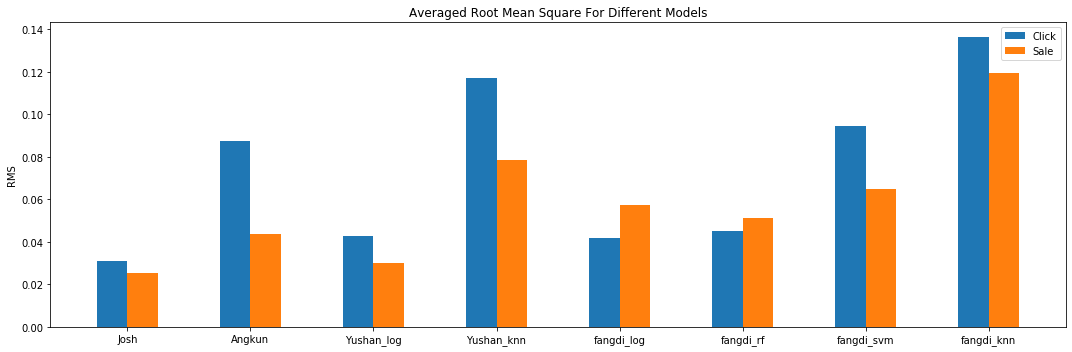

In [300]:
##plot the comparison of different models
x = np.array([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0])  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, np.sqrt(Click), width, label='Click')

rects2 = ax.bar(x + width/2, np.sqrt(Sale), width, label='Sale')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMS')
ax.set_title('Averaged Root Mean Square For Different Models')
ax.set_xticks(x)
ax.set_xticklabels(name)
ax.legend()



fig.tight_layout()

plt.show()

In [297]:
#take the average of model 1,3,5 and 6 as our prediction
pred['ave_Click_pred']=(pred['click_rate_Josh']+pred['click_rate_yushan_logreg']+pred['click_rate_fangdi_log']+pred['click_rate_fangdi_rf'])/4
pred['ave_Purchase_pred']=(pred['purchase_rate_Josh']+pred['purchase_rate_yushan_logreg']+pred['purchase_rate_fangdi_log']+pred['purchase_rate_fangdi_rf'])/4


In [298]:
pred.to_csv('predict_proba_averaged.csv')

In [301]:
Click=[0]*4
Sale=[0]*4
Click[0]=find_var(pred['click_rate_Josh'],pred['ave_Click_pred'])
Click[1]=find_var(pred['click_rate_yushan_logreg'],pred['ave_Click_pred'])
Click[2]=find_var(pred['click_rate_fangdi_log'],pred['ave_Click_pred'])
Click[3]=find_var(pred['click_rate_fangdi_rf'],pred['ave_Click_pred'])
Sale[0]=find_var(pred['purchase_rate_Josh'],pred['ave_Purchase_pred'])
Sale[1]=find_var(pred['purchase_rate_yushan_logreg'],pred['ave_Purchase_pred'])
Sale[2]=find_var(pred['purchase_rate_fangdi_log'],pred['ave_Purchase_pred'])
Sale[3]=find_var(pred['purchase_rate_fangdi_rf'],pred['ave_Purchase_pred'])

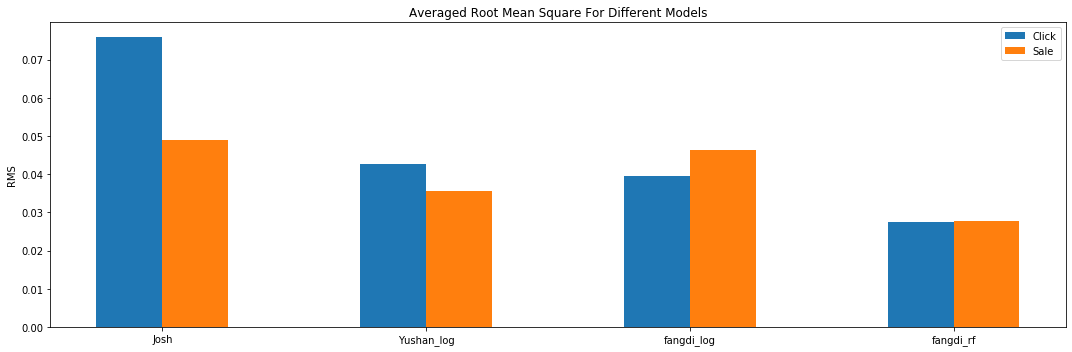

In [303]:
##plot the comparison of different models
name=['Josh','Yushan_log','fangdi_log','fangdi_rf']
x = np.array([0.0,1.0,2.0,3.0])  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, np.sqrt(Click), width, label='Click')

rects2 = ax.bar(x + width/2, np.sqrt(Sale), width, label='Sale')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMS')
ax.set_title('Averaged Root Mean Square For Different Models')
ax.set_xticks(x)
ax.set_xticklabels(name)
ax.legend()



fig.tight_layout()

plt.show()